In [21]:
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import collections
import torch
import torchvision
from torch.nn import functional as f
import time
import itertools
from moco_model import MoCo
from torch import nn
from torchvision.models import ResNet50_Weights


ORIGINAL_IMAGE = '../datasets/NDI_images/Integreted/Observed/circle_binaryzation_pics'
TARGET_IMAGE = '../datasets/NDI_images/Integreted/Calculated/'

class HistoryRecorder:
    def __init__(self, metrics_names: (list, tuple), parameter_names: (list, tuple)):
        self.data = collections.defaultdict(list)
        self.metrics_names = metrics_names
        self.parameter_names = parameter_names

    def cal_add(self, data, target: dict = None):
        if not target:
            target = self.data
        assert isinstance(data, dict)
        for k, v in data.items():
            if k not in target:
                target[k] = v
            else:
                for i, item in enumerate(v):
                    if isinstance(item, np.ndarray):
                        target[k][i] += item
                    elif isinstance(item, dict):
                        self.cal_add(item, target[k][i])

    def cal_divide(self, number, target=None):
        if not target:
            target = self.data
        assert isinstance(target, dict)
        for k, v in target.items():
            for i, item in enumerate(v):
                if isinstance(item, np.ndarray):
                    target[k][i] = target[k][i] / number
                elif isinstance(item, dict):
                    self.cal_divide(number, target[k][i])

    def add(self, data: dict):
        # if len(self.names) < len(args):
        #     raise IndexError('Too much values to record')
        # else:
        #     for i in range(min(len(self.names), len(args))):
        #         if isinstance(self.data[self.names[i]], list):
        #             self.data[self.names[i]].append(args[i])
        #         elif isinstance(self.data[self.names[i]], dict):
        #             for k, v in args[i].items():
        #                 if k not in self.data[self.names[i]]:
        #                     self.data[self.names[i]][k] = [v]
        #                 else:
        #                     self.data[self.names[i]][k].append(v)
        self.data.update(data)

    def reset(self):
        self.data = {}

    def __getitem__(self, name):
        return self.data[name]

def cal_accuracy_top_k(preds, label, top_k=(1, )):
    result = []
    max_k = max(top_k)
    sample_num = preds.shape[0]
    pred_scores, pred_labels = preds.topk(max_k, dim=1)
    pred_labels = pred_labels.t()
    correct = pred_labels.eq(label.view(1, -1).expand_as(pred_labels))
    for k in top_k:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        result.append(correct_k.item())
    return result

def image_pair_matching(net, original_image, matching_image):
    net.eval()
    q = net.encoder_q(original_image)
    q = f.normalize(q, dim=1)
    k = net.encoder_k(matching_image)
    k = f.normalize(k, dim=1)
    logits = torch.einsum('nc,ck->nk', [q, k.T])
    return logits

def train_moco_return_metrics_top_k(net, train_iter, val_iter, criterion, optimizer, epochs, device, tested_parameter, k_candidates=(10, )):
    # train_metrics = HistoryRecorder(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'], [list, dict, list, dict])

    to_tensor_func = torchvision.transforms.ToTensor()
    target_tensor = []
    for i in range(1, 185):
        target_tensor.append(to_tensor_func(Image.open(str(Path.joinpath(Path(TARGET_IMAGE), f'{i}.jpg')))).unsqueeze(0))
    target_tensor = torch.cat(target_tensor, dim=0)
    target_tensor = target_tensor.cuda(device)
    train_loss_record = []
    train_acc_record = {k: [] for k in k_candidates}
    val_loss_record = []
    val_acc_record = {k: [] for k in k_candidates}
    for epoch in range(epochs):
        net.cuda(device)
        total_loss = 0
        training_correct = collections.defaultdict(int)
        training_size = 0
        for origin, target, label in train_iter:
            net.train()
            origin, target, label = origin.cuda(device), target.cuda(device), label.cuda(device)
            output, labels = net(origin, target)
            loss = criterion(output, labels)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            net.eval()
            with torch.no_grad():
                for k, correct in zip(k_candidates, cal_accuracy_top_k(image_pair_matching(net, origin, target_tensor), label, top_k=k_candidates)):
                    training_correct[k] += correct
                training_size += origin.shape[0]
        net.eval()
        with torch.no_grad():
            val_loss = 0
            val_correct = collections.defaultdict(int)
            for origin, target, label in val_iter:
                origin, target, label = origin.cuda(device), target.cuda(device), label.cuda(device)
                output, labels = net(origin, target, evaluate=True)
                val_loss += f.cross_entropy(output, labels).item()
                for k, correct in zip(k_candidates, cal_accuracy_top_k(image_pair_matching(net, origin, target_tensor), label, top_k=k_candidates)):
                    val_correct[k] += correct
        val_acc = {k: correct / origin.shape[0] for k, correct in val_correct.items()}
        train_acc = {k: correct / training_size for k, correct in training_correct.items()}
        train_loss_record.append(total_loss / len(train_iter))
        for k, v in train_acc.items():
            train_acc_record[k].append(v)
        val_loss_record.append(val_loss / len(val_iter))
        for k, v in val_acc.items():
            val_acc_record[k].append(v)
        print(f'Epoch {epoch + 1}, Train_Loss {total_loss / len(train_iter)}, Val_loss {val_loss / len(val_iter)}')
        for k, acc in train_acc.items():
            print(f'Train_acc_top_{k} {round(acc, 4)}', end='\t')
        print()
        for k, acc in val_acc.items():
            print(f'Val_acc_top_{k} {round(acc, 2)}', end='\t')
        print()
    output = normalize_data_format({tuple(tested_parameter): (train_loss_record, train_acc_record, val_loss_record, val_acc_record)})
    return output

def normalize_data_format(data: dict, inner=False):
    result = collections.defaultdict(list)
    for k, v in data.items():
        if isinstance(v, tuple):
            for item in v:
                if isinstance(item, list):
                    result[k].append(np.array(item))
                else:
                    result[k].append(normalize_data_format(item, inner=True))
        elif isinstance(v, list):
            result[k].append(np.array(v))
        elif isinstance(v, dict):
            result[k].append(normalize_data_format(v, inner=True))
    if inner:
        for k, v in result.items():
            if isinstance(v, list) and len(v) == 1:
                result[k] = v[0]
    return result


def fmts_gen():
        line_styles = ['-', ':', '--', '-.']
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'w']
        for color in colors:
            for line_style in line_styles:
                yield color + line_style

def draw_graph(metrics, num_epochs: int, metrics_name: (list, tuple)):
    X = np.arange(1, num_epochs + 1, 1)
    fig, axes = plt.subplots((len(metrics) + 1) // 2, 2, figsize=(15, ((len(metrics) + 1) // 2) * 5))
    if hasattr(axes, 'flatten'):
        axes = axes.flatten()
    else:
        axes = [axes]
    for i, (k, v) in enumerate(metrics.items()):
        fmts = fmts_gen()
        plot_data = [v[0]]
        plot_data.extend(v[1].values())
        plot_data.append(v[2])
        plot_data.extend(v[3].values())
        for y, fmt in zip(plot_data, fmts):
            axes[i].plot(X, y, fmt)
        axes[i].set_xlabel('Epochs')
        axes[i].set_xlim([0, num_epochs + 1])
        axes[i].set_ylim([0, 4])
        axes[i].legend(['Train Loss'] + [f'Train Acc Top {k}' for k in v[1].keys()] + ['Val Loss'] + [f'Val Acc Top {k}' for k in v[3].keys()])
        axes[i].grid()
        axes[i].set_title(f'Training result when ' + ', '.join([f'{name} = {value}' for name, value in zip(metrics_name, k)]))
    plt.show()

def split_train_validation_randomly(original_path, target_path):
    original_images = list(sorted(list(map(str, list(Path(original_path).glob('*.jpg'))))))
    target_images = list(sorted(list(map(str, list(Path(target_path).glob('*.jpg'))))))
    images = list(zip(original_images, target_images))
    train_images, val_images = torch.utils.data.random_split(images, [160, 24])
    return train_images, val_images

class ThreeChannelNDIDatasetContrastiveLearningWithAug(Dataset):
    def __init__(self, images, evaluate=False):
        super(ThreeChannelNDIDatasetContrastiveLearningWithAug, self).__init__()
        if not evaluate:
            self.images = images[0]
        else:
            self.images = images[1]
        # 水平翻转 + 随机旋转 训练慢（100）但是效果好
        self.transforms = transforms.Compose([
            # transforms.GaussianBlur(kernel_size=3, sigma=0.7),
            # transforms.CenterCrop(150),
            # transforms.Resize(200),
            # transforms.RandomHorizontalFlip(0.5),
            # transforms.RandomRotation(30)
            ])
        self.evaluate = evaluate

    def __getitem__(self, idx):
        origin_path, target_path = self.images[idx]
        origin = Image.open(origin_path).convert('RGB')
        target = Image.open(target_path)
        if not self.evaluate:
            origin, target = self.transforms(torch.cat((transforms.ToTensor()(origin).unsqueeze(0), transforms.ToTensor()(target).unsqueeze(0)), dim=0))
        else:
            origin, target = transforms.ToTensor()(origin), transforms.ToTensor()(target)
        label = int(origin_path.split('/')[-1].split('.')[0]) - 1
        return origin, target, label

    def __len__(self):
        return len(self.images)

In [2]:
def k_fold_train_validation_split(original_path, target_path, k=5):
    original_images = list(sorted(list(map(str, list(Path(original_path).glob('*.jpg'))))))
    target_images = list(sorted(list(map(str, list(Path(target_path).glob('*.jpg'))))))
    images = list(zip(original_images, target_images))
    random.shuffle(images)
    per_k = 24
    for i in range(k):
        train_images = images[: i * per_k] + images[(i + 1) * per_k: ]
        val_images = images[i * per_k: (i + 1) * per_k]
        yield train_images, val_images

In [27]:
top_k_candidates = (10, 20, 30)
k = 7

#--------------------------#
# T=0.7 m=0.99 to be the best
# temps = [0.7]
# momentums = [0.999, 0.99]
# momentums = [0.99]
# k_value = 48
#--------------------------#

#--------------------------#
k_values = [32, 48, 64]
batch_sizes = [8, 16, 32]
#--------------------------#

# parameters = {'size of queue': k_values, 'batch size': batch_sizes}
# train_metrics = HistoryRecorder(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'], list(parameters.keys()))
parameters = ((48, 8), (64, 16))
train_metrics = HistoryRecorder(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'], list(('size of queue', 'batch size')))
for images in k_fold_train_validation_split(ORIGINAL_IMAGE, TARGET_IMAGE, k):
#    for parameter in itertools.product(*parameters.values()):
    for parameter in parameters:
        ### custom part to get parameters
        k_value = parameter[0]
        batch_size = parameter[1]
        if k_value % batch_size != 0:
            continue
        ### END

        train_dataset = ThreeChannelNDIDatasetContrastiveLearningWithAug(images, False)
        val_dataset = ThreeChannelNDIDatasetContrastiveLearningWithAug(images, True)
        train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))

        model = torchvision.models.resnet50
        model = MoCo(model, dim=512, K=k_value, T=0.7, m=0.99, model_type='resnet', weights=ResNet50_Weights.IMAGENET1K_V2, three_channel=True)
        device = torch.device('cuda:0')
        criterion = nn.CrossEntropyLoss().cuda(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
        start_time = time.time()
        metrics = train_moco_return_metrics_top_k(model, train_iter, val_iter, criterion, optimizer, 100, device, tested_parameter=parameter, k_candidates=top_k_candidates)
        end_time = time.time()
        train_metrics.cal_add(metrics)
train_metrics.cal_divide(k)

Epoch 1, Train_Loss 3.752349555492401, Val_loss 4.007957935333252
Train_acc_top_10 0.0563	Train_acc_top_20 0.1125	Train_acc_top_30 0.1437	
Val_acc_top_10 0.12	Val_acc_top_20 0.12	Val_acc_top_30 0.21	
Epoch 2, Train_Loss 3.873898446559906, Val_loss 3.952183961868286
Train_acc_top_10 0.0688	Train_acc_top_20 0.15	Train_acc_top_30 0.1938	
Val_acc_top_10 0.04	Val_acc_top_20 0.17	Val_acc_top_30 0.25	
Epoch 3, Train_Loss 3.8743959307670592, Val_loss 3.927494764328003
Train_acc_top_10 0.0437	Train_acc_top_20 0.0875	Train_acc_top_30 0.1437	
Val_acc_top_10 0.08	Val_acc_top_20 0.08	Val_acc_top_30 0.08	
Epoch 4, Train_Loss 3.8705520033836365, Val_loss 3.916166067123413
Train_acc_top_10 0.0625	Train_acc_top_20 0.1437	Train_acc_top_30 0.2062	
Val_acc_top_10 0.0	Val_acc_top_20 0.17	Val_acc_top_30 0.21	
Epoch 5, Train_Loss 3.867536795139313, Val_loss 3.9066944122314453
Train_acc_top_10 0.1062	Train_acc_top_20 0.1875	Train_acc_top_30 0.2875	
Val_acc_top_10 0.08	Val_acc_top_20 0.25	Val_acc_top_30 0.29	


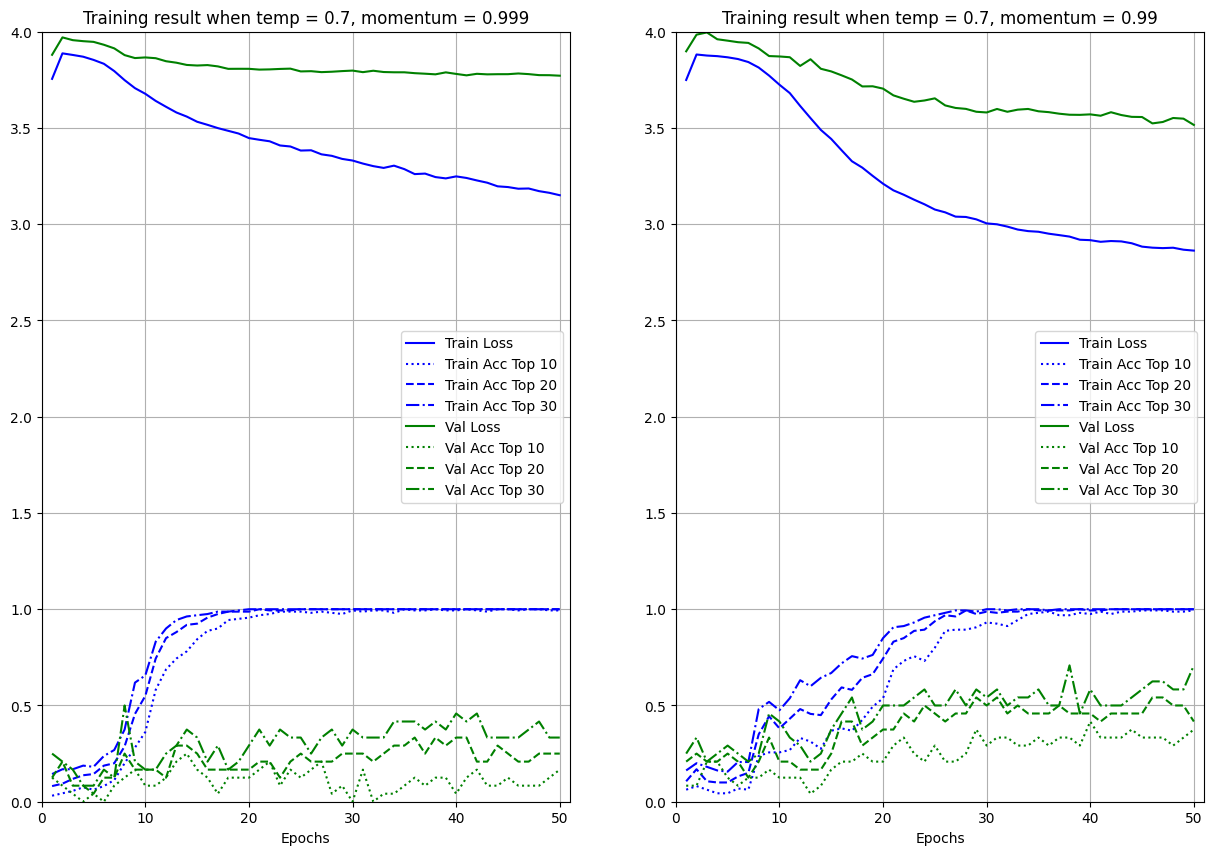

(0.7, 0.999) 10 mean 0.1125
(0.7, 0.999) 10 max 0.25
(0.7, 0.999) 20 mean 0.2458333333333333
(0.7, 0.999) 20 max 0.3333333333333333
(0.7, 0.999) 30 mean 0.3666666666666667
(0.7, 0.999) 30 max 0.5
(0.7, 0.99) 10 mean 0.3375
(0.7, 0.99) 10 max 0.4166666666666667
(0.7, 0.99) 20 mean 0.475
(0.7, 0.99) 20 max 0.5416666666666666
(0.7, 0.99) 30 mean 0.575
(0.7, 0.99) 30 max 0.7083333333333334


In [15]:
# Result of k-fold validation on three combinations of parameters and lr=0.01 using ImageNetweights V2

draw_graph(train_metrics.data, 50, ('temp', 'momentum'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-10:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')

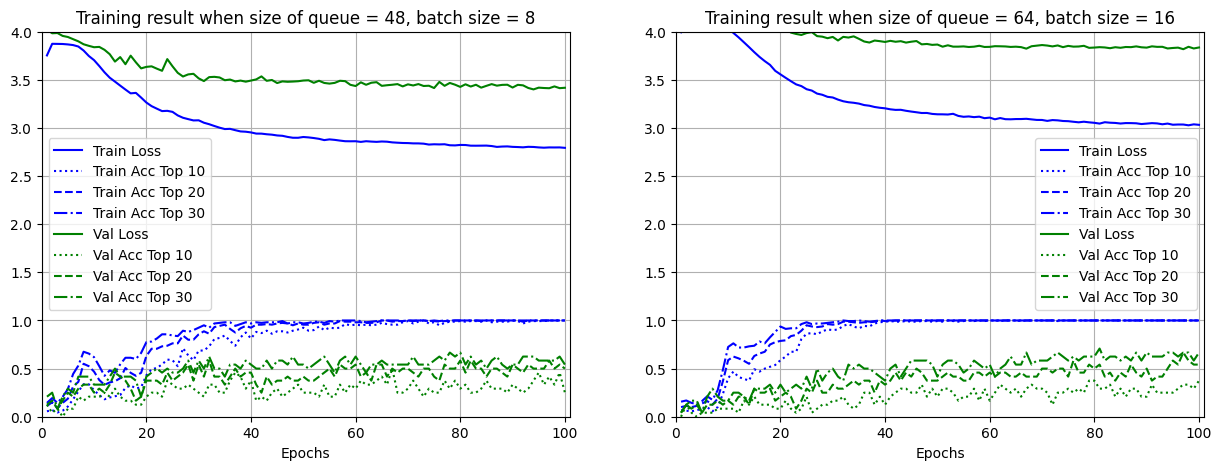

(48, 8) 10 mean 0.3458333333333333
(48, 8) 10 max 0.5
(48, 8) 20 mean 0.5125
(48, 8) 20 max 0.5833333333333334
(48, 8) 30 mean 0.5916666666666667
(48, 8) 30 max 0.6666666666666666
(64, 16) 10 mean 0.29583333333333334
(64, 16) 10 max 0.375
(64, 16) 20 mean 0.5166666666666668
(64, 16) 20 max 0.6666666666666666
(64, 16) 30 mean 0.6416666666666666
(64, 16) 30 max 0.7083333333333334


In [28]:
# Result of k-fold validation on combinations of (size of queue, batch size) and lr=0.01 using ImageNetweights V2
# (48, 8), (64, 16)

draw_graph(train_metrics.data, 100, ('size of queue', 'batch size'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-10:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')

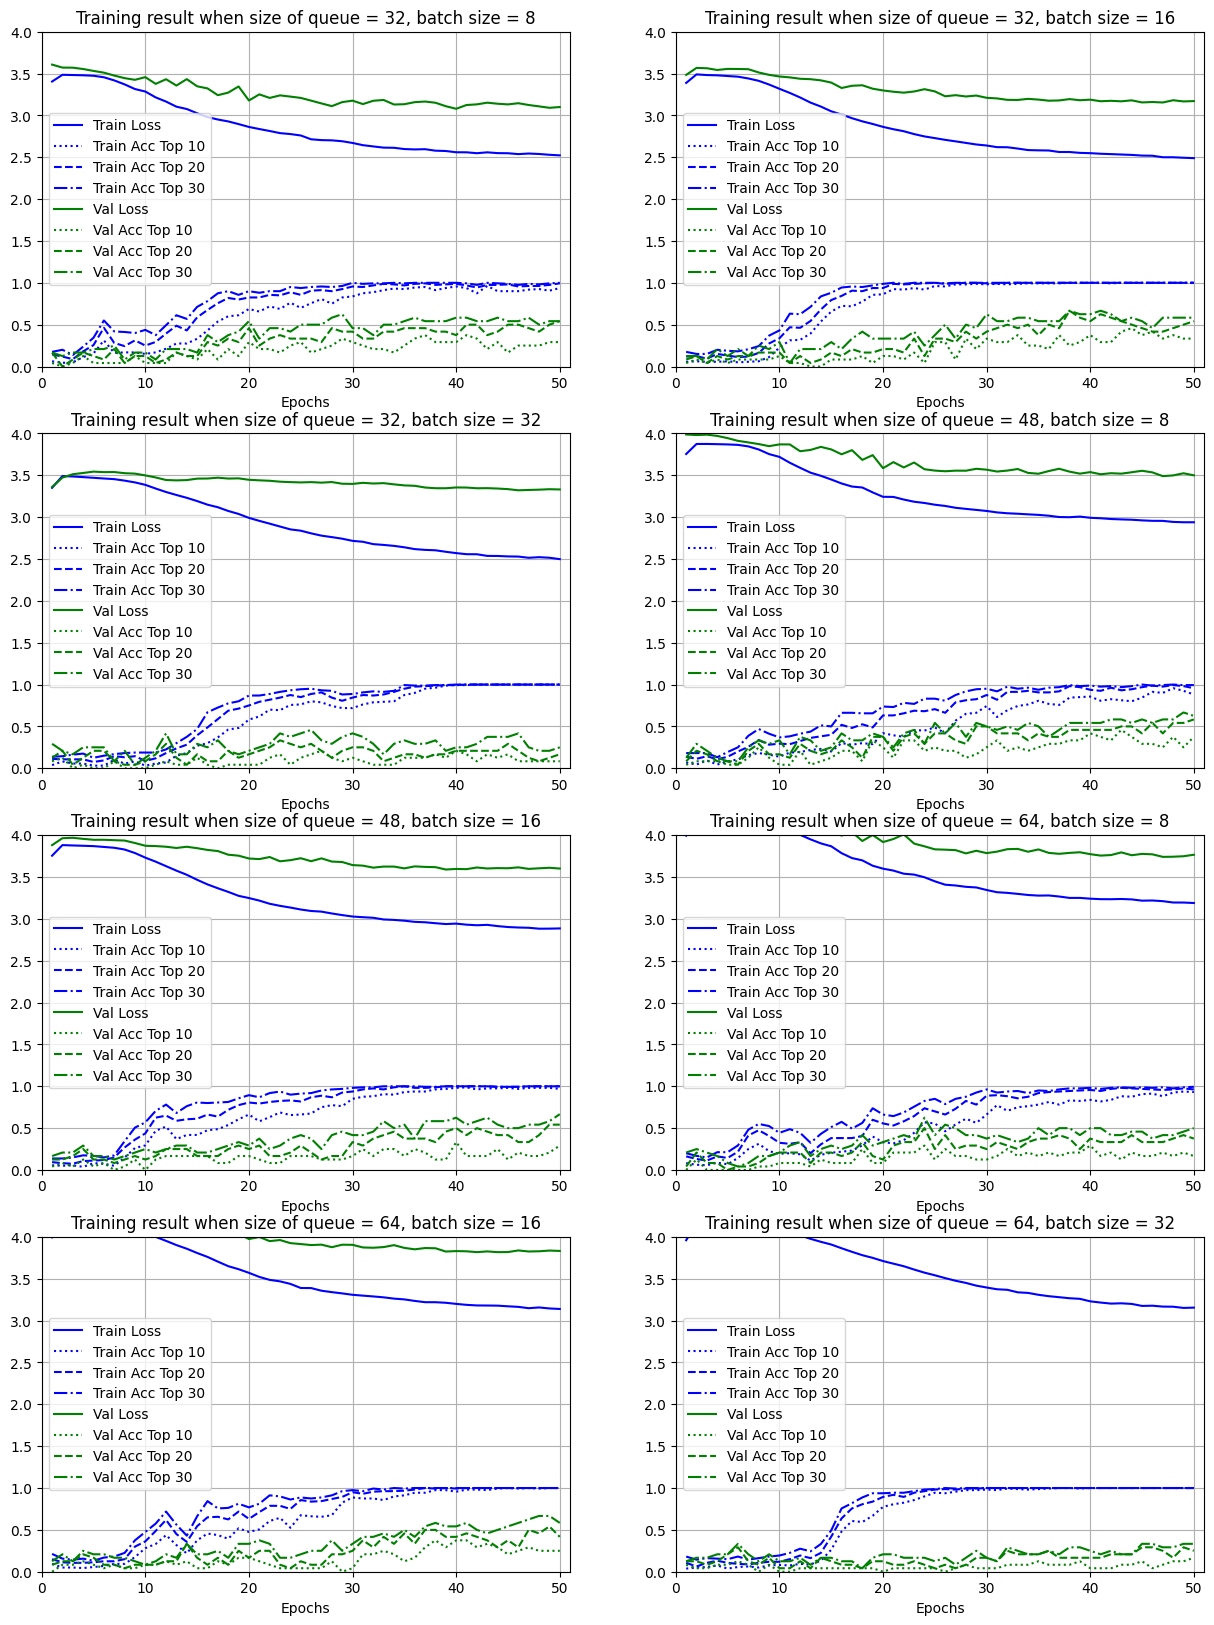

(32, 8) 10 mean 0.2708333333333333
(32, 8) 10 max 0.375
(32, 8) 20 mean 0.4708333333333334
(32, 8) 20 max 0.5416666666666666
(32, 8) 30 mean 0.55
(32, 8) 30 max 0.625
(32, 16) 10 mean 0.36250000000000004
(32, 16) 10 max 0.4583333333333333
(32, 16) 20 mean 0.5041666666666667
(32, 16) 20 max 0.6666666666666666
(32, 16) 30 mean 0.575
(32, 16) 30 max 0.6666666666666666
(32, 32) 10 mean 0.11249999999999998
(32, 32) 10 max 0.20833333333333334
(32, 32) 20 mean 0.18333333333333332
(32, 32) 20 max 0.3333333333333333
(32, 32) 30 mean 0.30000000000000004
(32, 32) 30 max 0.4583333333333333
(48, 8) 10 mean 0.3375
(48, 8) 10 max 0.4583333333333333
(48, 8) 20 mean 0.4958333333333333
(48, 8) 20 max 0.5833333333333334
(48, 8) 30 mean 0.5833333333333334
(48, 8) 30 max 0.6666666666666666
(48, 16) 10 mean 0.19166666666666668
(48, 16) 10 max 0.3333333333333333
(48, 16) 20 mean 0.4375
(48, 16) 20 max 0.5416666666666666
(48, 16) 30 mean 0.5625
(48, 16) 30 max 0.6666666666666666
(64, 8) 10 mean 0.179166666666

In [24]:
# Result of k-fold validation on combinations of (size of queue, batch size) and lr=0.01 using ImageNetweights V2

draw_graph(train_metrics.data, 50, ('size of queue', 'batch size'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-10:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')

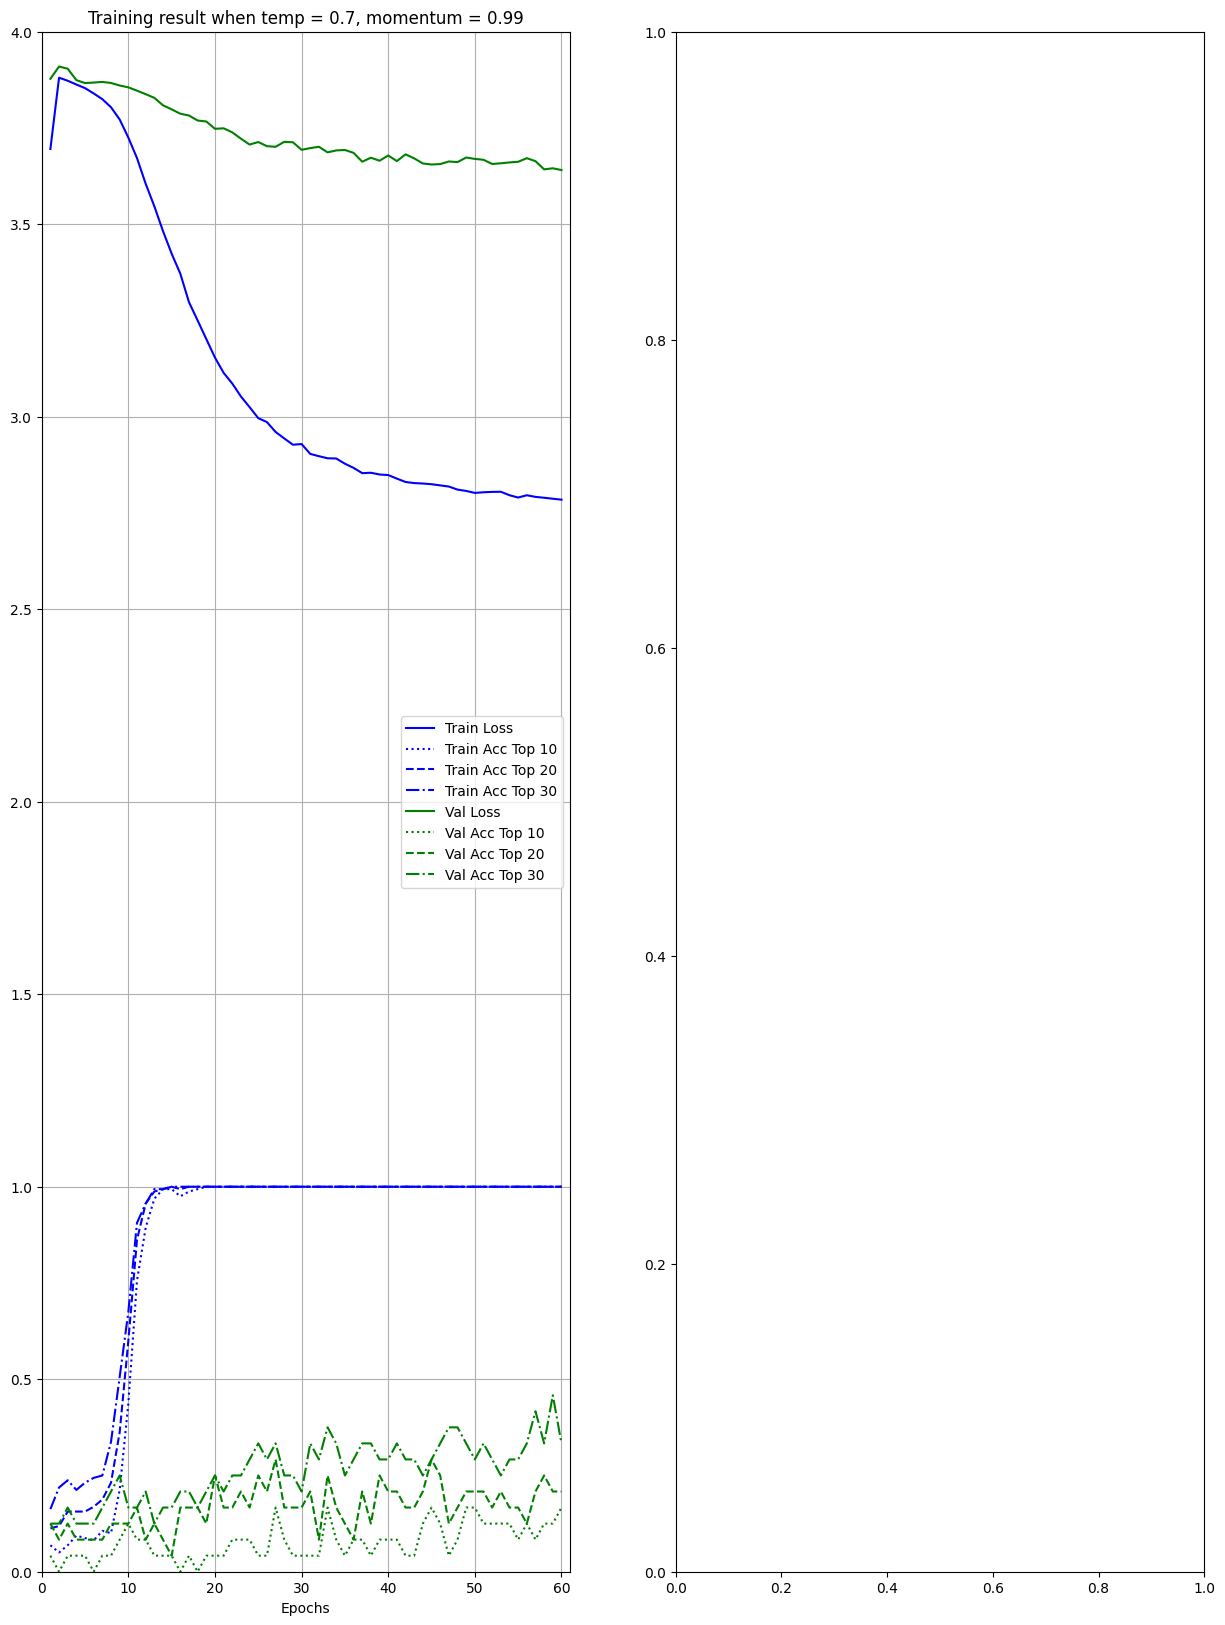

In [12]:
# Result of k-fold validation on two combinations of parameters and lr=0.001

draw_graph(train_metrics.data, 60, ('temp', 'momentum'))

In [9]:
# Result on random initialized weights

k = 7
k_candidates = (10, 20, 30)
to_tensor_func = torchvision.transforms.ToTensor()
device = torch.device('cuda:0')
target_tensor = []
for i in range(1, 185):
    target_tensor.append(to_tensor_func(Image.open(str(Path.joinpath(Path(TARGET_IMAGE), f'{i}.jpg')))).unsqueeze(0))
target_tensor = torch.cat(target_tensor, dim=0)
target_tensor = target_tensor.cuda(device)
total_acc = collections.defaultdict(float)
for images in k_fold_train_validation_split(ORIGINAL_IMAGE, TARGET_IMAGE, k):
    val_dataset = ThreeChannelNDIDatasetContrastiveLearningWithAug(images, True)
    val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))
    model = torchvision.models.resnet50
    model = MoCo(model, dim=512, K=48, T=0.7, m=0.99, model_type='resnet', weights=None, three_channel=True)
    model.cuda(device)
    to_tensor_func = torchvision.transforms.ToTensor()
    val_correct = collections.defaultdict(int)
    for origin, target, label in val_iter:
        origin, target, label = origin.cuda(device), target.cuda(device), label.cuda(device)
        output, labels = model(origin, target, evaluate=True)
        for k, correct in zip(k_candidates, cal_accuracy_top_k(image_pair_matching(model, origin, target_tensor), label, top_k=k_candidates)):
            val_correct[k] += correct
    val_acc = {k: correct / origin.shape[0] for k, correct in val_correct.items()}
    for key, value in val_acc.items():
        total_acc[key] += value
for key, value in total_acc.items():
    total_acc[key] = total_acc[key] / 7
print(total_acc)

defaultdict(<class 'float'>, {10: 0.03571428571428571, 20: 0.10714285714285714, 30: 0.1488095238095238})


In [8]:
# Result on ImageNet initialized weights

k = 7
k_candidates = (10, 20, 30)
to_tensor_func = torchvision.transforms.ToTensor()
device = torch.device('cuda:0')
target_tensor = []
for i in range(1, 185):
    target_tensor.append(to_tensor_func(Image.open(str(Path.joinpath(Path(TARGET_IMAGE), f'{i}.jpg')))).unsqueeze(0))
target_tensor = torch.cat(target_tensor, dim=0)
target_tensor = target_tensor.cuda(device)
total_acc = collections.defaultdict(float)
for images in k_fold_train_validation_split(ORIGINAL_IMAGE, TARGET_IMAGE, k):
    val_dataset = ThreeChannelNDIDatasetContrastiveLearningWithAug(images, True)
    val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))
    model = torchvision.models.resnet50
    model = MoCo(model, dim=512, K=48, T=0.7, m=0.99, model_type='resnet', weights=ResNet50_Weights.IMAGENET1K_V2, three_channel=True)
    model.cuda(device)
    to_tensor_func = torchvision.transforms.ToTensor()
    val_correct = collections.defaultdict(int)
    for origin, target, label in val_iter:
        origin, target, label = origin.cuda(device), target.cuda(device), label.cuda(device)
        output, labels = model(origin, target, evaluate=True)
        for k, correct in zip(k_candidates, cal_accuracy_top_k(image_pair_matching(model, origin, target_tensor), label, top_k=k_candidates)):
            val_correct[k] += correct
    val_acc = {k: correct / origin.shape[0] for k, correct in val_correct.items()}
    for key, value in val_acc.items():
        total_acc[key] += value
for key, value in total_acc.items():
    total_acc[key] = total_acc[key] / 7
print(total_acc)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/tornado/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

defaultdict(<class 'float'>, {10: 0.047619047619047616, 20: 0.10119047619047618, 30: 0.15476190476190474})
